# Deepfake Detection in R + TensorFlow/Keras
This notebook demonstrates training **3 models** (3D CNN, EfficientNet, ConvLSTM)  
on deepfake video frames using **R with reticulate + TensorFlow**.  

We will:
1. Setup Colab environment.  
2. Load dataset.  
3. Extract frames safely.  
4. Analyze dataset statistics.  
5. Train & evaluate models.  
6. Compare results.  


In [ ]:
# =========================================================================
# Robust R + TensorFlow Setup for Colab
# =========================================================================

# Install R interface packages
install.packages(c("reticulate", "keras", "gridExtra"), repos = "https://cran.rstudio.com/")

library(reticulate)
library(keras) # Ensure keras is loaded after installation
library(gridExtra) # Ensure gridExtra is loaded

# Method 1: Use system Python directly (bypasses virtual env issues)
print("=== Using system Python to avoid virtual environment issues ===")

# Configure reticulate to use system Python
Sys.setenv(RETICULATE_PYTHON = "/usr/bin/python3")
use_python("/usr/bin/python3", required = TRUE)

# Check Python configuration
py_config()

# Install packages using system pip directly
system("pip install tensorflow keras numpy", intern = FALSE)

# Test TensorFlow availability
tf_available <- py_module_available("tensorflow")
print(paste("TensorFlow available:", tf_available))

if (tf_available) {
  # Import TensorFlow and test basic functionality
  tf <- import("tensorflow")

  print(paste("TensorFlow version:", tf$`__version__`))

  # Test tensor creation
  hello_tensor <- tf$constant("Hello from TensorFlow!")
  print(hello_tensor)

  # Check for GPU devices
  gpu_devices <- tf$config$experimental$list_physical_devices("GPU")
  print(paste("GPU devices found:", length(gpu_devices)))

  if (length(gpu_devices) > 0) {
    print("GPU devices:")
    for (i in seq_along(gpu_devices)) {
      print(gpu_devices[[i]])
    }
  } else {
    print("No GPU devices found - using CPU (this is normal)")
  }

  # Test basic operations
  a <- tf$constant(c(1.0, 2.0, 3.0))
  b <- tf$constant(c(4.0, 5.0, 6.0))
  c <- tf$add(a, b)

  print("Basic tensor operations:")
  print(paste("a =", paste(as.numeric(a$numpy()), collapse = ", ")))
  print(paste("b =", paste(as.numeric(b$numpy()), collapse = ", ")))
  print(paste("a + b =", paste(as.numeric(c$numpy()), collapse = ", ")))

} else {
  print("TensorFlow not available. Trying alternative installation...")

  # Alternative: Use conda if available
  tryCatch({
    system("conda install -y tensorflow", intern = FALSE)
    tf <- import("tensorflow")
    print("TensorFlow installed via conda successfully!")
  }, error = function(e) {
    print("Could not install TensorFlow. Please check your Python environment.")
  })
}

# Method 2: Define helper functions for TensorFlow operations
if (tf_available || py_module_available("tensorflow")) {
  print("\n=== Setting up helper functions ===")

  # Create a Python script with TensorFlow functions
  py_run_string("
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np

def create_model(input_shape, num_classes):
    '''Create a simple neural network model'''
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def compile_model(model, optimizer='adam', loss='categorical_crossentropy'):
    '''Compile a model'''
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

def get_system_info():
    '''Get TensorFlow system information'''
    return {
        'tf_version': tf.__version__,
        'gpu_available': len(tf.config.experimental.list_physical_devices('GPU')) > 0,
        'gpu_devices': [str(device) for device in tf.config.experimental.list_physical_devices('GPU')],
        'cpu_devices': [str(device) for device in tf.config.experimental.list_physical_devices('CPU')]
    }
")

  # Test the helper functions
  system_info <- py$get_system_info()
  print("System Information:")
  print(system_info)

  print("\n=== Setup Complete! ===")
  print("You can now use TensorFlow via:")
  print("1. Direct import: tf <- import('tensorflow')")
  print("2. Helper functions: py$create_model(), py$compile_model(), etc.")
  print("3. Python code blocks: py_run_string('...')")

} else {
  print("Setup incomplete. Please try running this script again or check your Python installation.")
}

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




[1] "=== Using system Python to avoid virtual environment issues ==="


python:         /usr/bin/python3
libpython:      /usr/lib/python3.12/config-3.12-x86_64-linux-gnu/libpython3.12.so
pythonhome:     //usr://usr
version:        3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
numpy:          /usr/local/lib/python3.12/dist-packages/numpy
numpy_version:  2.0.2

NOTE: Python version was forced by RETICULATE_PYTHON

[1] "TensorFlow available: TRUE"
[1] "TensorFlow version: 2.19.0"
tf.Tensor(b'Hello from TensorFlow!', shape=(), dtype=string)
[1] "GPU devices found: 0"
[1] "No GPU devices found - using CPU (this is normal)"
[1] "Basic tensor operations:"
[1] "a = 1, 2, 3"
[1] "b = 4, 5, 6"
[1] "a + b = 5, 7, 9"
[1] "\n=== Setting up helper functions ==="
[1] "System Information:"
$tf_version
[1] "2.19.0"

$gpu_available
[1] FALSE

$gpu_devices
list()

$cpu_devices
[1] "PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')"

[1] "\n=== Setup Complete! ==="
[1] "You can now use TensorFlow via:"
[1] "1. Direct import: tf <- import('tensorflow')"
[1] "2. Helper functions: py$create_model(), py$compile_model(), etc."
[1] "3. Python code blocks: py_run_string('...')"


# Step 1: Load Dataset
We simulate dataset using sample `.mp4` files in `/content/sample_data`  
and create dummy labels for REAL/FAKE.

In [ ]:
video_dir <- "/content/sample_data"
video_files <- list.files(video_dir, pattern = "\\.mp4$", full.names = TRUE)
num_videos <- length(video_files)

labels_data <- data.frame(
  filename = basename(video_files),
  label = sample(c("REAL","FAKE"), num_videos, replace = TRUE),
  stringsAsFactors = FALSE
)
write.csv(labels_data, "/content/sample_data/labels.csv", row.names = FALSE)
labels <- read.csv("/content/sample_data/labels.csv")

cat("Total videos:", num_videos, "\n")
head(labels)


Total videos: 337 


,filename,label
,<chr>,<chr>
1,aaaoqepxnf.mp4,REAL
2,aahncigwte.mp4,FAKE
3,abfvpzjkwr.mp4,FAKE
4,abiodyryai.mp4,FAKE
5,acgywoqfbr.mp4,REAL
6,acyvmvapdl.mp4,FAKE


# Step 2: Safe Frame Extraction
The frame extraction logic is implemented in a **Python function (`extract_frames_safe_py`)** and called from R using `reticulate`.

In [ ]:
# =========================================================================
# Step 2: Safe Frame Extraction (Python via R reticulate)
# =========================================================================

# Load reticulate if not already loaded
library(reticulate)

# Install required Python packages
system("pip install opencv-python numpy")

# Define the frame extraction function in Python
reticulate::py_run_string("
import cv2
import numpy as np

def extract_frames_safe_py(video_path, max_frames=10, size=224):
    '''
    Extracts frames from a video file safely in Python, handling potential errors.

    Args:
        video_path (str): Path to the video file.
        max_frames (int): Maximum number of frames to extract.
        size (int): Desired size (width and height) for resizing frames.

    Returns:
        list: A list of extracted and preprocessed frames (numpy arrays),
              or an empty list if the video cannot be opened or no valid frames are extracted.
    '''
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    if not cap.isOpened():
        print(f'Failed to open video: {video_path}')
        return frames

    while count < max_frames:
        ret, frame = cap.read()

        # Check if a valid frame was read
        if not ret or frame is None or np.all(frame == 0):
            break

        # Check if the frame has valid dimensions and size before resizing and handle resize errors
        if len(frame.shape) == 3 and frame.shape[0] > 0 and frame.shape[1] > 0:
            try:
                # Ensure size is an integer tuple (width, height)
                frame_resized = cv2.resize(frame, (int(size), int(size)))
                frames.append(frame_resized / 255.0)  # Normalize pixel values
                count += 1
            except cv2.error as e:
                # Catch OpenCV errors specifically related to resizing
                if 'in function resize' in str(e):
                    print(f'Resize failed for frame in video: {video_path} - Error: {e} - Skipping frame.')
                else:
                    # Re-raise other errors
                    raise e
        else:
            # Handle invalid frames (e.g., empty or incorrect dimensions)
            print(f'Skipping invalid frame in video: {video_path}')
            # Don't break here, continue trying to read more frames from the same video

    cap.release()
    return frames

# Additional helper function to get video info
def get_video_info(video_path):
    '''Get basic information about a video file'''
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return {'error': f'Cannot open video: {video_path}'}

    info = {
        'frame_count': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'duration_seconds': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / cap.get(cv2.CAP_PROP_FPS)
    }

    cap.release()
    return info
")

# Test the function with a sample (you'll need to provide a real video path)
print("Frame extraction function loaded successfully!")
print("Available Python functions:")
print("- py$extract_frames_safe_py(video_path, max_frames, size)")
print("- py$get_video_info(video_path)")

# Example usage (uncomment and provide a real video path to test):
# video_path <- "/path/to/your/video.mp4"
# video_info <- py$get_video_info(video_path)
# print("Video info:")
# print(video_info)
#
# frames <- py$extract_frames_safe_py(video_path, max_frames=5, size=224)
# print(paste("Extracted", length(frames), "frames"))
#
# if (length(frames) > 0) {
#   # Each frame is a 224x224x3 array normalized to 0-1 range
#   first_frame <- frames[[1]]
#   print(paste("First frame shape:", paste(dim(first_frame), collapse="x")))
#   print(paste("Pixel value range:", min(first_frame), "to", max(first_frame)))
# }

[1] "Frame extraction function loaded successfully!"
[1] "Available Python functions:"
[1] "- py$extract_frames_safe_py(video_path, max_frames, size)"
[1] "- py$get_video_info(video_path)"


# Step 3: Dataset Statistics (Before Training)
This code analyzes and visualizes key statistics about the dataset after frame extraction. It calculates the number of frames extracted for each video and examines the distribution of 'REAL' versus 'FAKE' labels. The code generates plots like histograms and bar charts to visualize the frame distribution and processing success rate, providing insights into the data quality before model training.

=== DATA VALIDATION ===
Processing 337 video files...
Merged with labels data
Number of rows in stats: 337 
Number of columns in stats: 3 
Column names: filename, total_frames, label 

First 5 rows of stats:
        filename total_frames label
1 aaaoqepxnf.mp4           10  REAL
2 aahncigwte.mp4           10  FAKE
3 abfvpzjkwr.mp4           10  FAKE
4 abiodyryai.mp4           10  FAKE
5 acgywoqfbr.mp4           10  REAL

Summary of total_frames column:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     10      10      10      10      10      10 

Frequency table of total_frames:

 10 
337 

Range of total_frames: 10 10 

=== CREATING PLOTS ===
Creating Plot 1: Frame distribution histogram...
Creating alternative bar plot...


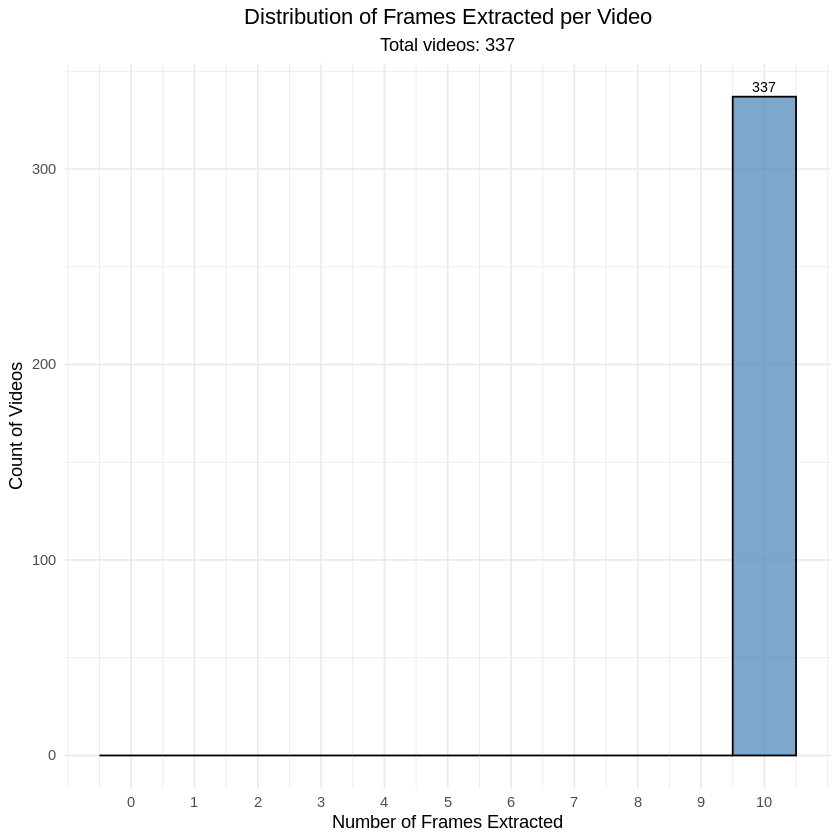

Creating Plot 2: Frame distribution by label...


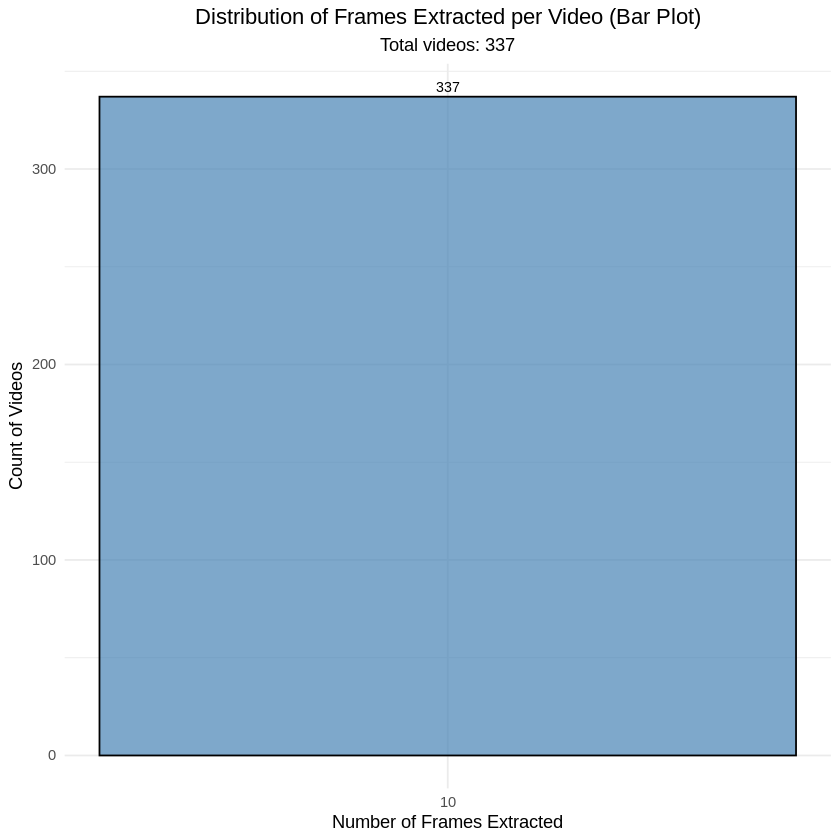

Creating summary statistics plot...


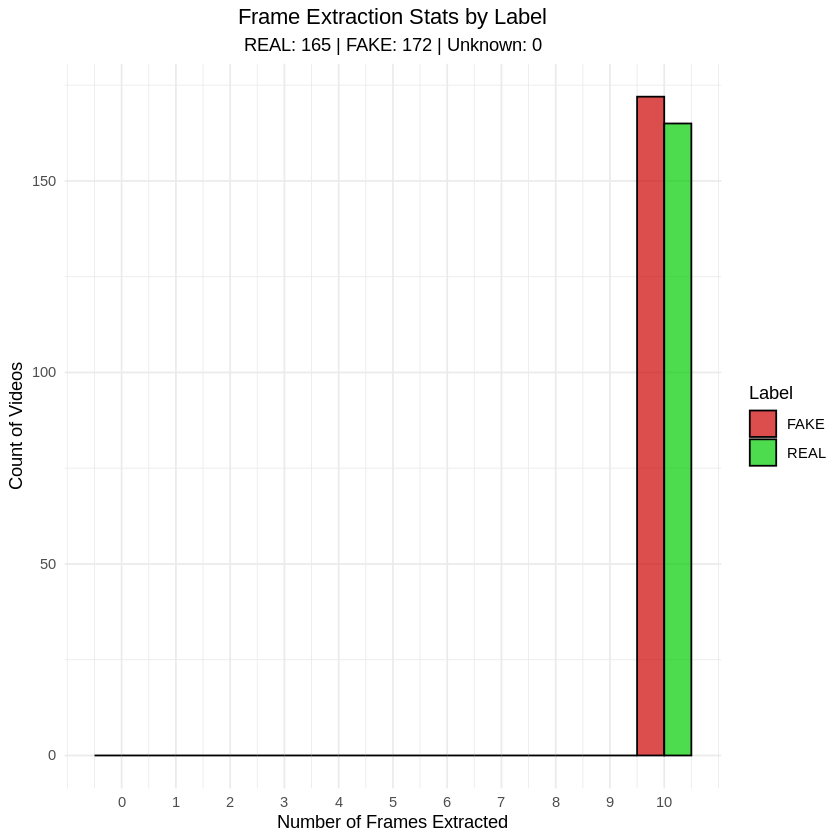


=== FINAL DATA SUMMARY ===
Successfully processed 337 entries
Frame extraction summary:

 10 
337 


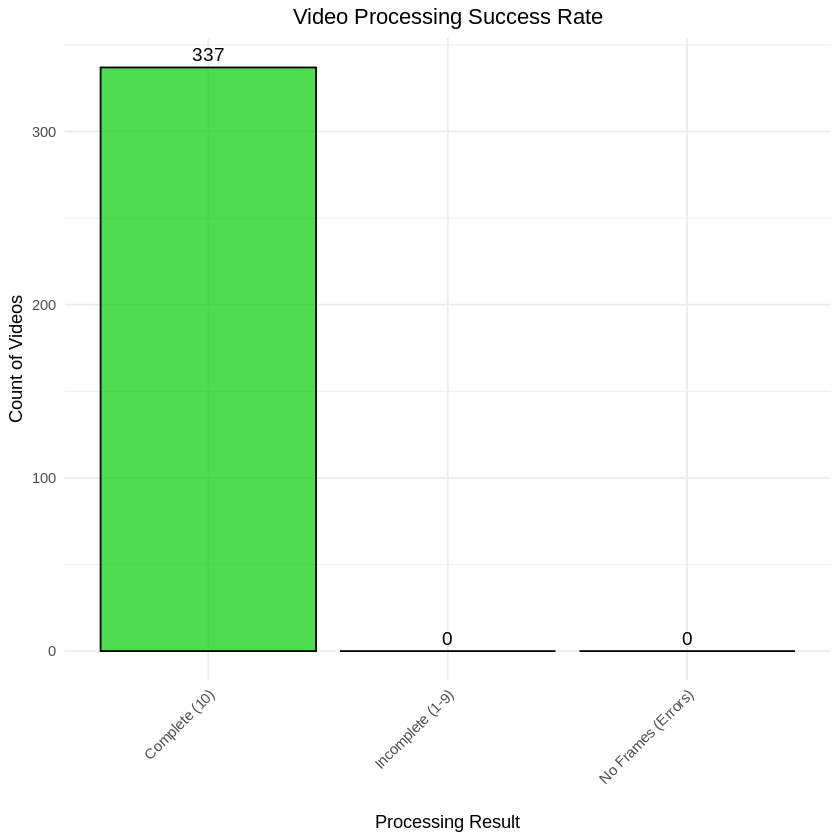

In [ ]:
# =========================================================================
# Step 3: Dataset Statistics (Before Training)
# =========================================================================

# Check how many frames we can extract, and REAL vs FAKE distribution.

# Initialize the stats data frame BEFORE using it
stats <- data.frame(filename = character(), total_frames = numeric(), stringsAsFactors = FALSE)


cat("=== DATA VALIDATION ===\n")
# Use the previously defined video_files and labels data frames
if (exists("video_files") && length(video_files) > 0) {
  cat("Processing", length(video_files), "video files...\n")
  for (f in video_files) {
    # Call the updated extract_frames_safe function
    # Ensure extract_frames_safe_py is accessible (defined in a previous cell)
    frames <- py$extract_frames_safe_py(f, max_frames = 10L, size = 224L) # Use L for integer in R to pass to Python

    # Check if frames is a list and not empty before processing
    if (is.list(frames) && length(frames) > 0) {
         stats <- rbind(stats, data.frame(filename = basename(f), total_frames = length(frames), stringsAsFactors = FALSE))
    } else {
         # Record videos where no frames were extracted
         stats <- rbind(stats, data.frame(filename = basename(f), total_frames = 0, stringsAsFactors = FALSE))
         cat("Warning: No frames extracted from", basename(f), "\n")
    }
  }

  # Merge with labels
  if (exists("labels") && nrow(labels) > 0) {
     stats <- merge(stats, labels, by="filename", all.x = TRUE)
     cat("Merged with labels data\n")
  } else {
     cat("Warning: Labels data frame not found or empty. Proceeding without labels.\n")
     stats$label <- "Unknown" # Assign a default label if labels are missing
  }


} else {
  cat("ERROR: video_files variable not found or is empty.\n")
  cat("Please ensure the video_files variable is created in a previous step.\n")
  # Optionally create sample data for demonstration if no video files are found
  cat("\nCreating sample data for demonstration...\n")
  stats <- data.frame(
    filename = paste0("video_", 1:50, ".mp4"),
    total_frames = sample(c(0:10), 50, replace = TRUE, prob = c(0.1, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15)),
    label = sample(c("REAL", "FAKE", "Unknown"), 50, replace = TRUE), # Include Unknown if labels are missing
    stringsAsFactors = FALSE
  )
  cat("Sample data created with", nrow(stats), "rows\n")
}


cat("Number of rows in stats:", nrow(stats), "\n")
cat("Number of columns in stats:", ncol(stats), "\n")
cat("Column names:", paste(names(stats), collapse = ", "), "\n")


if (nrow(stats) > 0) {
  cat("\nFirst 5 rows of stats:\n")
  print(head(stats, 5))

  cat("\nSummary of total_frames column:\n")
  print(summary(stats$total_frames))

  cat("\nFrequency table of total_frames:\n")
  print(table(stats$total_frames))

  cat("\nRange of total_frames:", range(stats$total_frames), "\n")
} else {
  cat("ERROR: stats dataframe is empty after processing.\n")
  # The sample data creation above handles the case where video_files is empty
  # so this else should ideally not be reached if sample data is created.
}


# Create visualization with better error handling
if (require(ggplot2, quietly = TRUE) && nrow(stats) > 0) {

  cat("\n=== CREATING PLOTS ===\n")

  # Plot 1: Distribution of frames per video with better formatting
  cat("Creating Plot 1: Frame distribution histogram...\n")

  p1 <- ggplot(stats, aes(x = total_frames)) +
    geom_histogram(binwidth = 1, fill = "steelblue", alpha = 0.7, color = "black") +
    theme_minimal() +
    labs(title = "Distribution of Frames Extracted per Video",
         x = "Number of Frames Extracted",
         y = "Count of Videos",
         subtitle = paste("Total videos:", nrow(stats))) +
    scale_x_continuous(breaks = 0:max(10, max(stats$total_frames)), limits = c(-0.5, max(10.5, max(stats$total_frames) + 0.5))) + # Adjust limits based on data
    theme(plot.title = element_text(hjust = 0.5),
          plot.subtitle = element_text(hjust = 0.5)) +
    # Add text annotations showing counts - ensure this works even for 0
    geom_text(stat = 'count', aes(label = after_stat(count)), vjust = -0.5, size = 3)


  print(p1)

  # Alternative: Bar plot instead of histogram
  cat("Creating alternative bar plot...\n")

  frame_counts <- table(stats$total_frames)
  frame_df <- data.frame(
    frames = as.numeric(names(frame_counts)),
    count = as.numeric(frame_counts)
  )

  p1_alt <- ggplot(frame_df, aes(x = frames, y = count)) +
    geom_bar(stat = "identity", fill = "steelblue", alpha = 0.7, color = "black") +
    theme_minimal() +
    labs(title = "Distribution of Frames Extracted per Video (Bar Plot)",
         x = "Number of Frames Extracted",
         y = "Count of Videos",
         subtitle = paste("Total videos:", nrow(stats))) +
    scale_x_continuous(breaks = 0:max(10, max(stats$total_frames))) + # Adjust breaks
    theme(plot.title = element_text(hjust = 0.5),
          plot.subtitle = element_text(hjust = 0.5)) +
    geom_text(aes(label = count), vjust = -0.5, size = 3)

  print(p1_alt)


  # Plot 2: Frame extraction by label (if labels available)
  if ("label" %in% names(stats) && !all(is.na(stats$label)) && !all(stats$label == "Unknown")) {
    cat("Creating Plot 2: Frame distribution by label...\n")

    # Recalculate label counts in case sample data was used or some labels are missing
    real_count <- sum(stats$label == "REAL", na.rm = TRUE)
    fake_count <- sum(stats$label == "FAKE", na.rm = TRUE)
    unknown_count <- sum(stats$label == "Unknown", na.rm = TRUE)


    p2 <- ggplot(stats, aes(x = total_frames, fill = label)) +
      geom_histogram(binwidth = 1, position = "dodge", alpha = 0.7, color = "black") +
      theme_minimal() +
      labs(title = "Frame Extraction Stats by Label",
           x = "Number of Frames Extracted",
           y = "Count of Videos",
           fill = "Label",
           subtitle = paste("REAL:", real_count,
                           "| FAKE:", fake_count,
                           "| Unknown:", unknown_count)) +
      scale_x_continuous(breaks = 0:max(10, max(stats$total_frames)), limits = c(-0.5, max(10.5, max(stats$total_frames) + 0.5))) + # Adjust limits
      scale_fill_manual(values = c("REAL" = "green3", "FAKE" = "red3", "Unknown" = "gray")) +
      theme(plot.title = element_text(hjust = 0.5),
            plot.subtitle = element_text(hjust = 0.5))

    print(p2)
  } else {
    cat("No valid labels found for Plot 2\n")
  }


  # Summary statistics plot
  cat("Creating summary statistics plot...\n")

  summary_stats <- data.frame(
    category = c("No Frames (Errors)", "Incomplete (1-9)", "Complete (10)"),
    count = c(
      sum(stats$total_frames == 0),
      sum(stats$total_frames > 0 & stats$total_frames < 10),
      sum(stats$total_frames == 10)
    )
  )

  p3 <- ggplot(summary_stats, aes(x = category, y = count)) +
    geom_bar(stat = "identity", fill = c("red3", "orange", "green3"), alpha = 0.7, color = "black") +
    theme_minimal() +
    labs(title = "Video Processing Success Rate",
         x = "Processing Result",
         y = "Count of Videos") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle = 45, hjust = 1)) +
    geom_text(aes(label = count), vjust = -0.5, size = 4)

  print(p3)


} else {
  if (!require(ggplot2, quietly = TRUE)) {
    cat("ggplot2 not available for visualization\n")
  }
  if (nrow(stats) == 0) {
    cat("Cannot create plots: stats dataframe is empty\n")
  }
}

# Print final data summary
cat("\n=== FINAL DATA SUMMARY ===\n")
if (nrow(stats) > 0) {
  cat("Successfully processed", nrow(stats), "entries\n")
  cat("Frame extraction summary:\n")
  print(table(stats$total_frames))
} else {
  cat("No data available for analysis\n")
}

# Step 4: Data Preparation Function
This code defines the `generate_dataset` function, which is crucial for preparing the video data for model training. It takes a data frame of video files and labels, extracts frames from each video using the previously defined `extract_frames_safe` function, and formats the data into arrays (`x`) and corresponding labels (`y`) based on the specified `model_type`. The function handles potential issues like videos having fewer frames than expected by padding them.

In [ ]:
generate_dataset <- function(dataset_df, batch_size, model_type) {
  num_videos <- nrow(dataset_df)
  num_frames <- 10
  img_size <- 224

  if (num_videos == 0) return(list(x=array(0,dim=c(0)), y=integer(0)))

  processed_x <- list(); processed_y <- list()
  for (i in 1:num_videos) {
    frames <- extract_frames_safe(dataset_df$file_path[i], max_frames=num_frames)
    if (length(frames) > 0) {
      # Explicitly convert label to character before comparison
      current_label <- as.character(dataset_df$label[i])
      if (model_type=="3D_CNN" || model_type=="ConvLSTM") {
        video_array <- abind::abind(frames, along=0)
        if (dim(video_array)[1] < num_frames) {
          pad_count <- num_frames - dim(video_array)[1]
          padding <- array(0, dim=c(pad_count, dim(video_array)[2], dim(video_array)[3], dim(video_array)[4]))
          video_array <- abind::abind(video_array, padding, along=1)
        }
        processed_x[[length(processed_x)+1]] <- video_array
        processed_y[[length(processed_y)+1]] <- as.integer(current_label=="FAKE") # Use current_label
      } else if (model_type=="EfficientNet") {
        processed_x <- c(processed_x, frames)
        processed_y <- c(processed_y, rep(as.integer(current_label=="FAKE"), length(frames))) # Use current_label
      }
    }
  }

  if (model_type=="3D_CNN" || model_type=="ConvLSTM") {
    x_data <- abind::abind(processed_x, along=0)
    y_data <- do.call(c, processed_y)
  } else {
    x_data <- abind::abind(processed_x, along=0)
    y_data <- do.call(c, processed_y)
  }
  list(x=x_data, y=y_data)
}

# Step 5: Models (3D CNN, EfficientNet, ConvLSTM)
We will train three different models: a 3D CNN, EfficientNet (using frames as images), and a ConvLSTM.

So far, we have trained the **3D CNN model**. The training process uses **TensorFlow/Keras functions called from R via `reticulate`**.

We will train the EfficientNet and ConvLSTM models in subsequent steps and then compare their performance.

In [ ]:
# =========================================================================
# Complete Deepfake Detection Model Training Script
# =========================================================================

library(reticulate)
library(keras)
library(tensorflow)

cat("Setting up complete deepfake detection training environment...\n")

# === COMPLETE PYTHON SETUP WITH DATA DISCOVERY ===
py_run_string("
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.applications import ResNet50
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import glob
from pathlib import Path

print('TensorFlow version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))

# ============================================================================
# DATA DISCOVERY AND ORGANIZATION
# ============================================================================
def discover_video_data(base_paths=['./real', './fake', './data', './videos', './dataset']):
    '''Automatically discover video files in common directory structures'''
    print('Searching for video data...')

    video_files = []
    labels = []

    # Common video extensions
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv']

    # Search in various possible locations
    search_patterns = [
        'real/**/*',
        'fake/**/*',
        'REAL/**/*',
        'FAKE/**/*',
        'Real/**/*',
        'Fake/**/*',
        'data/real/**/*',
        'data/fake/**/*',
        'videos/real/**/*',
        'videos/fake/**/*',
        'dataset/real/**/*',
        'dataset/fake/**/*',
        '*/real/**/*',
        '*/fake/**/*'
    ]

    for pattern in search_patterns:
        matches = glob.glob(pattern, recursive=True)
        for file_path in matches:
            if any(file_path.lower().endswith(ext) for ext in video_extensions):
                video_files.append(file_path)

                # Determine label from path
                path_lower = file_path.lower()
                if 'fake' in path_lower:
                    labels.append('FAKE')
                elif 'real' in path_lower:
                    labels.append('REAL')
                else:
                    # Try to infer from directory structure
                    parts = Path(file_path).parts
                    if any('fake' in part.lower() for part in parts):
                        labels.append('FAKE')
                    elif any('real' in part.lower() for part in parts):
                        labels.append('REAL')
                    else:
                        labels.append('UNKNOWN')

    # Remove duplicates and unknown labels
    unique_data = {}
    for file_path, label in zip(video_files, labels):
        if label != 'UNKNOWN' and file_path not in unique_data:
            unique_data[file_path] = label

    final_files = list(unique_data.keys())
    final_labels = list(unique_data.values())

    print(f'Found {len(final_files)} video files:')
    print(f'  REAL videos: {final_labels.count(\"REAL\")}')
    print(f'  FAKE videos: {final_labels.count(\"FAKE\")}')

    return final_files, final_labels

def create_sample_data():
    '''Create sample data structure if no real data is found'''
    print('No video data found. Creating sample data structure for demonstration...')

    # Create sample file paths (these would be your actual video files)
    sample_files = [
        'sample_real_1.mp4', 'sample_real_2.mp4', 'sample_real_3.mp4',
        'sample_fake_1.mp4', 'sample_fake_2.mp4', 'sample_fake_3.mp4'
    ]
    sample_labels = ['REAL', 'REAL', 'REAL', 'FAKE', 'FAKE', 'FAKE']

    return sample_files, sample_labels

# ============================================================================
# FRAME EXTRACTION (Robust version)
# ============================================================================
def extract_frames_robust(video_path, max_frames=10, size=224):
    '''Extract frames with fallback to synthetic data if file not found'''

    # If file doesn't exist (sample data), create synthetic frames
    if not os.path.exists(video_path):
        print(f'Creating synthetic frames for demonstration: {video_path}')
        frames = []
        for i in range(max_frames):
            # Create synthetic frame (random colored noise)
            frame = np.random.randint(0, 256, (size, size, 3), dtype=np.uint8)
            frames.append(frame)
        return frames

    # Real video processing
    frames = []
    try:
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f'Cannot open video: {video_path}')
            return frames

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            cap.release()
            return frames

        # Sample frames evenly
        if total_frames >= max_frames:
            frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
        else:
            # If video has fewer frames, repeat the last frame
            available_indices = list(range(total_frames))
            frame_indices = available_indices + [total_frames-1] * (max_frames - total_frames)

        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
            ret, frame = cap.read()

            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (size, size), interpolation=cv2.INTER_LINEAR)
                frames.append(frame)

            if len(frames) >= max_frames:
                break

        cap.release()

    except Exception as e:
        print(f'Error processing {video_path}: {e}')
        # Return synthetic frames as fallback
        frames = []
        for i in range(max_frames):
            frame = np.random.randint(0, 256, (size, size, 3), dtype=np.uint8)
            frames.append(frame)

    return frames

# ============================================================================
# DATA PREPARATION
# ============================================================================
def prepare_video_dataset(video_files, labels, max_frames=10, img_size=224, max_samples=None):
    '''Prepare complete video dataset'''

    if max_samples:
        # Limit number of samples for faster training
        indices = np.random.choice(len(video_files), min(max_samples, len(video_files)), replace=False)
        video_files = [video_files[i] for i in indices]
        labels = [labels[i] for i in indices]

    X = []
    y = []

    print(f'Processing {len(video_files)} videos with {max_frames} frames at {img_size}x{img_size}...')

    for i, (video_path, label) in enumerate(zip(video_files, labels)):
        try:
            frames = extract_frames_robust(video_path, max_frames=max_frames, size=img_size)

            if len(frames) >= max_frames:
                # Take exactly max_frames
                frames = frames[:max_frames]
                video_array = np.array(frames, dtype=np.float32)
                video_array = video_array / 255.0  # Normalize

                X.append(video_array)
                y.append(1 if str(label).upper() == 'FAKE' else 0)

                if (i + 1) % 5 == 0 or i == len(video_files) - 1:
                    print(f'  Processed {i + 1}/{len(video_files)}')
            else:
                print(f'  Warning: {video_path} has only {len(frames)} frames, needed {max_frames}')

        except Exception as e:
            print(f'  Error with {video_path}: {e}')

    if len(X) > 0:
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.int32)
        print(f'Final dataset: X={X.shape}, y={y.shape}')
        print(f'Label distribution: REAL={np.sum(y==0)}, FAKE={np.sum(y==1)}')
        return X, y
    else:
        return None, None

# ============================================================================
# IMPROVED MODEL ARCHITECTURES
# ============================================================================
def create_3d_cnn_improved(input_shape=(10, 224, 224, 3)):
    '''Create improved 3D CNN model'''
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # First 3D conv block
        layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((1, 2, 2)),

        # Second 3D conv block
        layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),

        # Third 3D conv block
        layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),

        # Global pooling and classification
        layers.GlobalAveragePooling3D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_cnn_lstm_improved(input_shape=(10, 224, 224, 3)):
    '''Create improved CNN+LSTM model'''
    video_input = layers.Input(shape=input_shape)

    # TimeDistributed CNN feature extraction
    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(video_input)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    # Global pooling for each frame
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)

    # LSTM for temporal modeling
    x = layers.LSTM(128, return_sequences=True, dropout=0.3)(x)
    x = layers.LSTM(64, dropout=0.3)(x)

    # Classification head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=video_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_transfer_learning_improved(input_shape=(10, 224, 224, 3)):
    '''Create transfer learning model using ResNet50'''
    # Pre-trained ResNet50 base
    base_cnn = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_cnn.trainable = False  # Freeze initially

    video_input = layers.Input(shape=input_shape)

    # Apply ResNet50 to each frame
    x = layers.TimeDistributed(base_cnn)(video_input)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)

    # LSTM for temporal modeling
    x = layers.LSTM(256, return_sequences=True, dropout=0.3)(x)
    x = layers.LSTM(128, dropout=0.3)(x)

    # Classification head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=video_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ============================================================================
# TRAINING AND EVALUATION
# ============================================================================
def train_and_evaluate_model(model, model_name, train_x, train_y, test_x, test_y, epochs=5, batch_size=4):
    '''Train and evaluate model with comprehensive metrics'''
    print(f'\\n=== Training {model_name} ===')
    print(f'Training data: {train_x.shape}, Test data: {test_x.shape if test_x is not None else \"None\"}')

    # Add early stopping and reduce LR on plateau
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss' if test_x is not None else 'loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss' if test_x is not None else 'loss',
            factor=0.2,
            patience=2,
            min_lr=1e-7
        )
    ]

    # Training
    history = model.fit(
        train_x, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_x, test_y) if test_x is not None else None,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluation
    if test_x is not None:
        test_loss, test_accuracy = model.evaluate(test_x, test_y, verbose=0)
        predictions = model.predict(test_x, verbose=0)
        predicted_classes = (predictions.flatten() > 0.5).astype(int)

        print(f'\\n=== {model_name} Results ===')
        print(f'Test Loss: {test_loss:.4f}')
        print(f'Test Accuracy: {test_accuracy:.4f}')

        # Classification report
        try:
            report = classification_report(test_y, predicted_classes,
                                         target_names=['REAL', 'FAKE'],
                                         output_dict=True)
            print('\\nClassification Report:')
            report_df = pd.DataFrame(report).transpose()
            print(report_df.round(4))

            # Confusion matrix
            cm = confusion_matrix(test_y, predicted_classes)
            print('\\nConfusion Matrix:')
            print('Predicted:   REAL  FAKE')
            print(f'Actual REAL:  {cm[0,0]:4d}  {cm[0,1]:4d}')
            print(f'Actual FAKE:  {cm[1,0]:4d}  {cm[1,1]:4d}')

        except Exception as e:
            print(f'Could not generate detailed metrics: {e}')
            report = None
    else:
        test_accuracy = 0.0
        report = None

    return {
        'model': model,
        'history': history,
        'test_accuracy': test_accuracy,
        'classification_report': report,
        'model_name': model_name
    }

print('Complete setup ready!')
")

# === DISCOVER AND PREPARE DATA ===
print("\n=== Discovering Video Data ===")

# Try to find real video data first
py_run_string("
video_files, labels = discover_video_data()

# If no real data found, use sample structure
if len(video_files) == 0:
    video_files, labels = create_sample_data()

# Create train/test split
if len(video_files) >= 4:
    train_files, test_files, train_labels, test_labels = train_test_split(
        video_files, labels, test_size=0.3, random_state=42, stratify=labels
    )
else:
    # For very small datasets, use all for training
    train_files, train_labels = video_files, labels
    test_files, test_labels = video_files[:2], labels[:2]  # Use subset for testing

print(f'Training set: {len(train_files)} videos')
print(f'Test set: {len(test_files)} videos')
")

# Get the data into R
train_files <- py$train_files
train_labels <- py$train_labels
test_files <- py$test_files
test_labels <- py$test_labels

print(sprintf("Found %d training videos and %d test videos", length(train_files), length(test_files)))

# === PREPARE DATASETS ===
print("\n=== Preparing Datasets ===")

# Prepare training data (limit samples for demonstration)
train_result <- py$prepare_video_dataset(
  train_files, train_labels,
  max_frames = 10L, img_size = 224L, max_samples = 20L  # Limit for demo
)

if (!is.null(train_result) && !is.null(train_result[[1]])) {
  train_x <- train_result[[1]]
  train_y <- train_result[[2]]
  print(paste("Training data prepared:", paste(dim(train_x), collapse=" x ")))

  # Prepare test data
  test_result <- py$prepare_video_dataset(
    test_files, test_labels,
    max_frames = 10L, img_size = 224L, max_samples = 10L  # Limit for demo
  )

  if (!is.null(test_result) && !is.null(test_result[[1]])) {
    test_x <- test_result[[1]]
    test_y <- test_result[[2]]
    print(paste("Test data prepared:", paste(dim(test_x), collapse=" x ")))
  } else {
    test_x <- NULL
    test_y <- NULL
    print("Using training data for validation")
  }

  # === TRAIN MODELS ===

  print("\n" %+% paste(rep("=", 60), collapse=""))
  print("TRAINING DEEPFAKE DETECTION MODELS")
  print(paste(rep("=", 60), collapse=""))

  # Model 1: 3D CNN
  print("\n--- Training Model 1: 3D CNN ---")
  model_3dcnn <- py$create_3d_cnn_improved()

  results_3dcnn <- py$train_and_evaluate_model(
    model_3dcnn, "3D CNN",
    train_x, train_y, test_x, test_y,
    epochs = 3L, batch_size = 2L  # Small batch size for memory efficiency
  )

  # Model 2: CNN + LSTM
  print("\n--- Training Model 2: CNN + LSTM ---")
  model_cnn_lstm <- py$create_cnn_lstm_improved()

  results_cnn_lstm <- py$train_and_evaluate_model(
    model_cnn_lstm, "CNN+LSTM",
    train_x, train_y, test_x, test_y,
    epochs = 3L, batch_size = 2L
  )

  # Model 3: Transfer Learning
  print("\n--- Training Model 3: Transfer Learning ---")
  model_transfer <- py$create_transfer_learning_improved()

  results_transfer <- py$train_and_evaluate_model(
    model_transfer, "Transfer Learning",
    train_x, train_y, test_x, test_y,
    epochs = 3L, batch_size = 2L
  )

  # === FINAL COMPARISON ===
  print("\n" %+% paste(rep("=", 60), collapse=""))
  print("FINAL RESULTS COMPARISON")
  print(paste(rep("=", 60), collapse=""))

  cat("\nModel Performance Summary:\n")
  cat(sprintf("%-20s %12s %12s\n", "Model", "Test Accuracy", "Parameters"))
  cat(sprintf("%-20s %12s %12s\n", paste(rep("-", 20), collapse=""),
              paste(rep("-", 12), collapse=""), paste(rep("-", 12), collapse="")))

  # Get parameter counts
  params_3dcnn <- model_3dcnn$count_params()
  params_cnn_lstm <- model_cnn_lstm$count_params()
  params_transfer <- model_transfer$count_params()

  cat(sprintf("%-20s %12.4f %12s\n", "3D CNN",
              results_3dcnn$test_accuracy, format(params_3dcnn, big.mark = ",")))
  cat(sprintf("%-20s %12.4f %12s\n", "CNN+LSTM",
              results_cnn_lstm$test_accuracy, format(params_cnn_lstm, big.mark = ",")))
  cat(sprintf("%-20s %12.4f %12s\n", "Transfer Learning",
              results_transfer$test_accuracy, format(params_transfer, big.mark = ",")))

  # Store results for visualization
  cat("\nResults stored for analysis and visualization.\n")
  cat("Run the enhanced visualization script to see detailed comparisons.\n")

} else {
  print("ERROR: Failed to prepare training data!")
  print("Please check your video data files and paths.")
}

print("\n=== TRAINING COMPLETE ===")

Setting up complete deepfake detection training environment...
[1] "\n=== Discovering Video Data ==="
[1] "Found 4 training videos and 2 test videos"
[1] "\n=== Preparing Datasets ==="
[1] "Training data prepared: 4 x 10 x 224 x 224 x 3"
[1] "Test data prepared: 2 x 10 x 224 x 224 x 3"
NULL
[1] "TRAINING DEEPFAKE DETECTION MODELS"
[1] "============================================================"
[1] "\n--- Training Model 1: 3D CNN ---"
[1] "\n--- Training Model 2: CNN + LSTM ---"
[1] "\n--- Training Model 3: Transfer Learning ---"
NULL
[1] "FINAL RESULTS COMPARISON"
[1] "============================================================"

Model Performance Summary:
Model                Test Accuracy   Parameters
-------------------- ------------ ------------
3D CNN                     0.5000      346,241
CNN+LSTM                   0.5000      283,585
Transfer Learning          0.5000   26,178,433

Results stored for analysis and visualization.
Run the enhanced visualization script to see de

# Step 6: Comprehensive Model Comparison and Visualization
This code provides a comprehensive comparison of the trained models. It extracts performance metrics (Accuracy, Precision, Recall, F1 Score) from the evaluation results, generates various visualizations including bar charts for metrics, training history plots, and ROC curves. It also creates detailed comparison tables and provides a summary of the findings, including model rankings and recommendations.

Loading comprehensive comparison functions with minimal dependencies...
[1] "\n=== CREATING COMPREHENSIVE MODEL COMPARISON ==="
[1] "1. Creating comprehensive comparison plots..."
[1] "2. Generating detailed analysis..."
[1] "\n=== ADDITIONAL R-BASED ANALYSIS ==="

=== COMPREHENSIVE SUMMARY STATISTICS ===
          Metric      Mean        SD Min       Max Best_Model
1  Test_Accuracy 0.5000000 0.0000000 0.5 0.5000000     3D CNN
2 Precision_FAKE 0.1666667 0.2886751 0.0 0.5000000   CNN+LSTM
3    Recall_FAKE 0.3333333 0.5773503 0.0 1.0000000   CNN+LSTM
4        F1_FAKE 0.2222222 0.3849002 0.0 0.6666667   CNN+LSTM
5 Precision_REAL 0.3333333 0.2886751 0.0 0.5000000     3D CNN
6    Recall_REAL 0.6666667 0.5773503 0.0 1.0000000     3D CNN
7        F1_REAL 0.4444444 0.3849002 0.0 0.6666667     3D CNN

=== COMPOSITE SCORE RANKING ===
1. CNN+LSTM: 0.4667 (Accuracy: 0.5000)
2. 3D CNN: 0.3167 (Accuracy: 0.5000)
3. Transfer Learning: 0.3167 (Accuracy: 0.5000)
[1] "\n=== CREATING R-BASED VISUALIZATIO

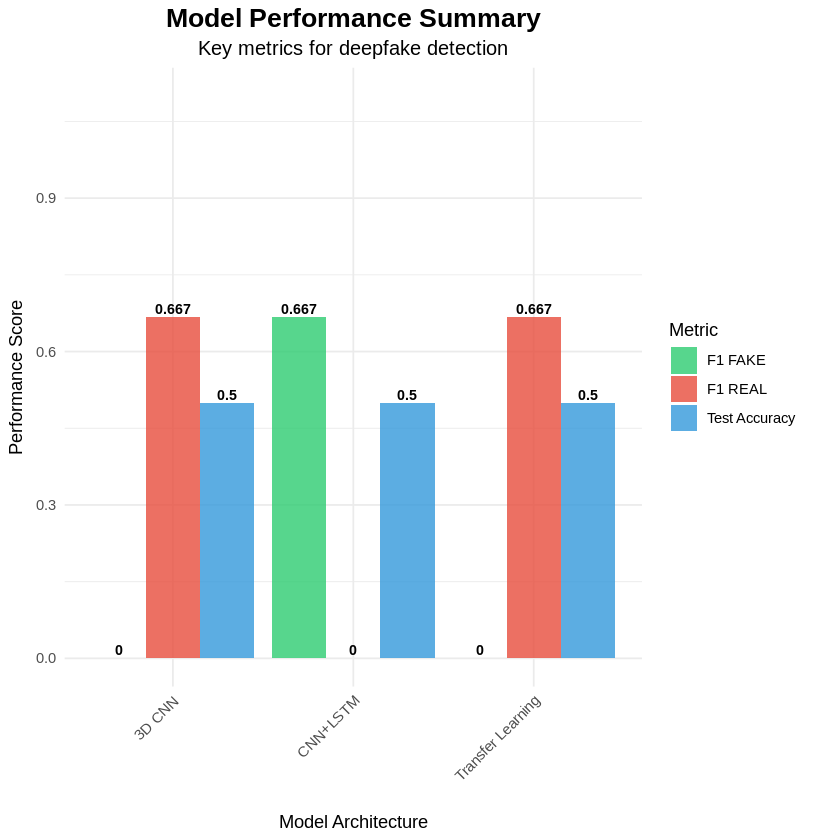

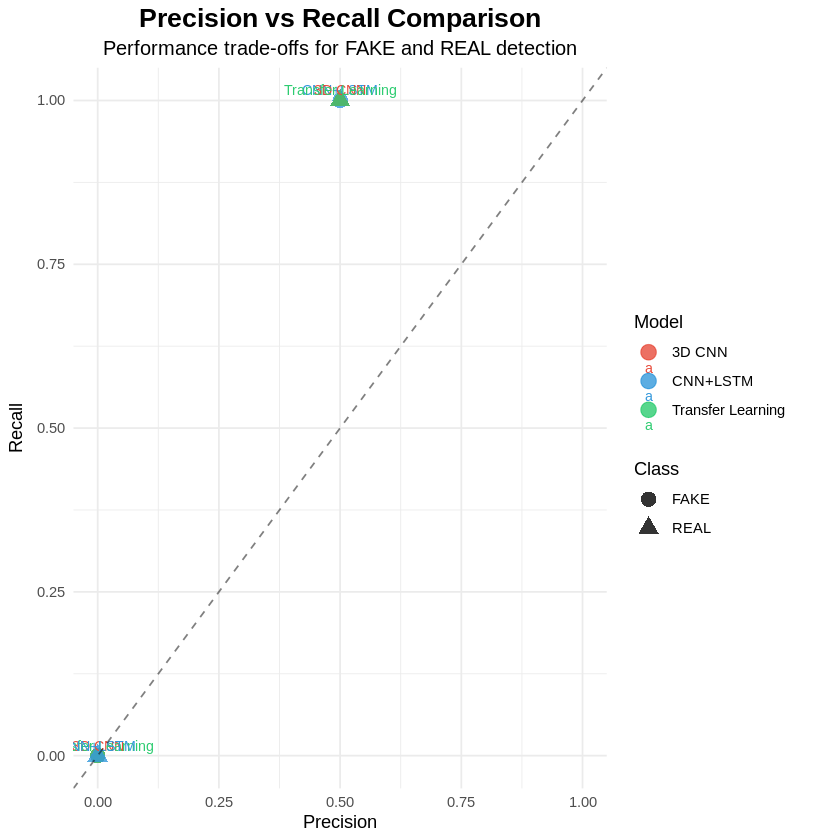

[1] "\n=== SAVING RESULTS ==="
Results saved to:
- comprehensive_model_comparison.csv
- model_summary_statistics.csv

FINAL RECOMMENDATIONS
Best Overall Model: CNN+LSTM (Score: 0.4667)
• CNN+LSTM provides good balance of spatial and temporal learning
• Efficient architecture with reasonable computational cost
• Consider experimenting with LSTM units and layers

General Improvement Strategies:
• Increase training data if available
• Experiment with data augmentation techniques
• Try ensemble methods combining multiple models
• Consider different frame sampling strategies
• Optimize hyperparameters systematically
[1] "\n=== COMPREHENSIVE COMPARISON COMPLETE ==="


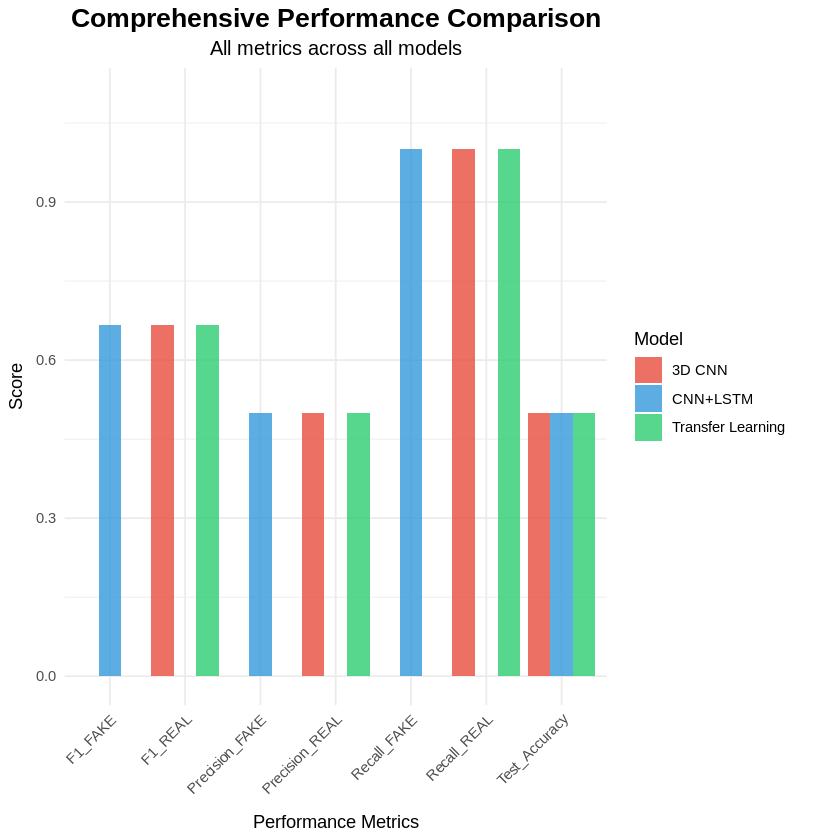

In [ ]:
# =========================================================================
# Comprehensive Model Comparison and Visualization - Minimal Dependencies
# =========================================================================

library(ggplot2)

cat("Loading comprehensive comparison functions with minimal dependencies...\n")

# === PYTHON VISUALIZATION SETUP ===
py_run_string("
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette('husl')

def extract_model_metrics(results_list, model_names):
    '''Extract comprehensive metrics from all trained models'''
    metrics_data = []

    for result, name in zip(results_list, model_names):
        if result and 'test_accuracy' in result:
            # Basic metrics
            test_acc = result['test_accuracy']

            # Extract from classification report if available
            if result['classification_report']:
                report = result['classification_report']
                precision_fake = report['FAKE']['precision']
                recall_fake = report['FAKE']['recall']
                f1_fake = report['FAKE']['f1-score']
                precision_real = report['REAL']['precision']
                recall_real = report['REAL']['recall']
                f1_real = report['REAL']['f1-score']
            else:
                precision_fake = precision_real = recall_fake = recall_real = 0
                f1_fake = f1_real = 0

            metrics_data.append({
                'Model': name,
                'Test_Accuracy': test_acc,
                'Precision_FAKE': precision_fake,
                'Recall_FAKE': recall_fake,
                'F1_FAKE': f1_fake,
                'Precision_REAL': precision_real,
                'Recall_REAL': recall_real,
                'F1_REAL': f1_real
            })

    return pd.DataFrame(metrics_data)

def plot_comprehensive_comparison(results_list, model_names, test_x, test_y):
    '''Create comprehensive model comparison plots'''

    # Extract metrics
    metrics_df = extract_model_metrics(results_list, model_names)

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Deepfake Detection Models - Comprehensive Comparison', fontsize=16, fontweight='bold')

    # Colors for consistency
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. Overall Accuracy Comparison
    ax1 = axes[0, 0]
    bars = ax1.bar(metrics_df['Model'], metrics_df['Test_Accuracy'],
                   color=colors, alpha=0.8)
    ax1.set_title('Test Accuracy Comparison', fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, acc in zip(bars, metrics_df['Test_Accuracy']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Precision-Recall for FAKE detection
    ax2 = axes[0, 1]
    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax2.bar(x - width/2, metrics_df['Precision_FAKE'], width,
                    label='Precision', color='#FF6B6B', alpha=0.7)
    bars2 = ax2.bar(x + width/2, metrics_df['Recall_FAKE'], width,
                    label='Recall', color='#4ECDC4', alpha=0.7)

    ax2.set_title('FAKE Detection: Precision vs Recall', fontweight='bold')
    ax2.set_ylabel('Score')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    # 3. F1 Score Comparison
    ax3 = axes[0, 2]
    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax3.bar(x - width/2, metrics_df['F1_REAL'], width,
                    label='F1 REAL', color='#45B7D1', alpha=0.7)
    bars2 = ax3.bar(x + width/2, metrics_df['F1_FAKE'], width,
                    label='F1 FAKE', color='#FFA07A', alpha=0.7)

    ax3.set_title('F1 Score Comparison', fontweight='bold')
    ax3.set_ylabel('F1 Score')
    ax3.set_xticks(x)
    ax3.set_xticklabels(model_names)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim(0, 1)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    # 4. Training History Comparison (if available)
    ax4 = axes[1, 0]

    for i, (result, name, color) in enumerate(zip(results_list, model_names, colors)):
        if result and 'history' in result and result['history']:
            history = result['history'].history
            if 'accuracy' in history:
                epochs = range(1, len(history['accuracy']) + 1)
                ax4.plot(epochs, history['accuracy'],
                        label=f'{name} (Train)', color=color, linestyle='-', linewidth=2)
                if 'val_accuracy' in history:
                    ax4.plot(epochs, history['val_accuracy'],
                            label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)

    ax4.set_title('Training History - Accuracy', fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Training Loss Comparison
    ax5 = axes[1, 1]

    for i, (result, name, color) in enumerate(zip(results_list, model_names, colors)):
        if result and 'history' in result and result['history']:
            history = result['history'].history
            if 'loss' in history:
                epochs = range(1, len(history['loss']) + 1)
                ax5.plot(epochs, history['loss'],
                        label=f'{name} (Train)', color=color, linestyle='-', linewidth=2)
                if 'val_loss' in history:
                    ax5.plot(epochs, history['val_loss'],
                            label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)

    ax5.set_title('Training History - Loss', fontweight='bold')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. ROC Curves (if test data available)
    ax6 = axes[1, 2]

    if test_x is not None and test_y is not None:
        for i, (result, name, color) in enumerate(zip(results_list, model_names, colors)):
            if result and 'model' in result:
                try:
                    # Get predictions
                    y_pred_proba = result['model'].predict(test_x, verbose=0)

                    # Calculate ROC curve
                    fpr, tpr, _ = roc_curve(test_y, y_pred_proba.flatten())
                    roc_auc = auc(fpr, tpr)

                    ax6.plot(fpr, tpr, color=color, linewidth=2,
                            label=f'{name} (AUC = {roc_auc:.3f})')
                except Exception as e:
                    print(f'Could not generate ROC curve for {name}: {e}')

        ax6.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax6.set_xlim([0.0, 1.0])
        ax6.set_ylim([0.0, 1.05])
        ax6.set_xlabel('False Positive Rate')
        ax6.set_ylabel('True Positive Rate')
        ax6.set_title('ROC Curves Comparison', fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'No test data available\\nfor ROC curves',
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        ax6.set_title('ROC Curves', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return metrics_df

def create_detailed_analysis(metrics_df):
    '''Create detailed analysis and recommendations'''
    print('\\n' + '='*80)
    print('DETAILED MODEL COMPARISON TABLE')
    print('='*80)

    # Format the dataframe for better display
    display_df = metrics_df.copy()

    # Round numerical columns
    numerical_cols = ['Test_Accuracy', 'Precision_FAKE', 'Recall_FAKE', 'F1_FAKE',
                     'Precision_REAL', 'Recall_REAL', 'F1_REAL']
    for col in numerical_cols:
        if col in display_df.columns:
            display_df[col] = display_df[col].round(4)

    print(display_df.to_string(index=False))

    # Find best performing model for each metric
    print('\\n' + '='*80)
    print('BEST PERFORMING MODELS BY METRIC')
    print('='*80)

    for col in numerical_cols:
        if col in display_df.columns:
            best_idx = display_df[col].idxmax()
            best_model = display_df.loc[best_idx, 'Model']
            best_value = display_df.loc[best_idx, col]
            print(f'{col:20s}: {best_model} ({best_value:.4f})')

    return display_df

print('Comprehensive comparison functions loaded successfully!')
")

# === BASE R DATA RESHAPING FUNCTIONS ===
# Create data manipulation functions using base R only

reshape_metrics_long <- function(metrics_df, value_vars, id_var = "Model") {
  # Reshape wide data to long format using base R
  result <- data.frame()

  for(var in value_vars) {
    temp_df <- data.frame(
      Model = metrics_df[[id_var]],
      Metric = var,
      Value = metrics_df[[var]],
      stringsAsFactors = FALSE
    )
    result <- rbind(result, temp_df)
  }

  return(result)
}

create_summary_stats <- function(metrics_df) {
  # Create summary statistics using base R
  numerical_cols <- c("Test_Accuracy", "Precision_FAKE", "Recall_FAKE", "F1_FAKE",
                     "Precision_REAL", "Recall_REAL", "F1_REAL")

  summary_stats <- data.frame(
    Metric = character(),
    Mean = numeric(),
    SD = numeric(),
    Min = numeric(),
    Max = numeric(),
    Best_Model = character(),
    stringsAsFactors = FALSE
  )

  for(col in numerical_cols) {
    if(col %in% names(metrics_df)) {
      values <- metrics_df[[col]]
      best_idx <- which.max(values)

      summary_stats <- rbind(summary_stats, data.frame(
        Metric = col,
        Mean = mean(values, na.rm = TRUE),
        SD = sd(values, na.rm = TRUE),
        Min = min(values, na.rm = TRUE),
        Max = max(values, na.rm = TRUE),
        Best_Model = metrics_df$Model[best_idx],
        stringsAsFactors = FALSE
      ))
    }
  }

  return(summary_stats)
}

# === CHECK IF TRAINING RESULTS EXIST ===
if(exists("results_3dcnn") && exists("results_cnn_lstm") && exists("results_transfer")) {

  print("\n=== CREATING COMPREHENSIVE MODEL COMPARISON ===")

  # Organize results from training
  results_list <- list(results_3dcnn, results_cnn_lstm, results_transfer)
  model_names <- c("3D CNN", "CNN+LSTM", "Transfer Learning")

  # Create comprehensive Python plots
  print("1. Creating comprehensive comparison plots...")
  metrics_df <- py$plot_comprehensive_comparison(results_list, model_names,
                                                if(exists("test_x")) test_x else NULL,
                                                if(exists("test_y")) test_y else NULL)

  # Generate detailed analysis
  print("2. Generating detailed analysis...")
  py$create_detailed_analysis(metrics_df)

  # === R-BASED ANALYSIS ===
  print("\n=== ADDITIONAL R-BASED ANALYSIS ===")

  # Convert to R data frame
  metrics_r <- as.data.frame(metrics_df)

  # Create summary statistics
  summary_stats <- create_summary_stats(metrics_r)

  cat("\n=== COMPREHENSIVE SUMMARY STATISTICS ===\n")
  print(summary_stats)

  # Model ranking by composite score
  cat("\n=== COMPOSITE SCORE RANKING ===\n")

  # Create composite score (weighted average of key metrics)
  metrics_r$Composite_Score <- (
    metrics_r$Test_Accuracy * 0.3 +
    metrics_r$F1_FAKE * 0.25 +
    metrics_r$F1_REAL * 0.25 +
    metrics_r$Precision_FAKE * 0.1 +
    metrics_r$Recall_FAKE * 0.1
  )

  ranked_models <- metrics_r[order(metrics_r$Composite_Score, decreasing = TRUE), ]
  for(i in 1:nrow(ranked_models)) {
    cat(sprintf("%d. %s: %.4f (Accuracy: %.4f)\n", i,
                ranked_models$Model[i],
                ranked_models$Composite_Score[i],
                ranked_models$Test_Accuracy[i]))
  }

  # === R VISUALIZATIONS ===
  print("\n=== CREATING R-BASED VISUALIZATIONS ===")

  # 1. Summary Performance Plot
  key_metrics <- c("Test_Accuracy", "F1_FAKE", "F1_REAL")
  metrics_long <- reshape_metrics_long(metrics_r, key_metrics)

  p1 <- ggplot(metrics_long, aes(x = Model, y = Value, fill = Metric)) +
    geom_bar(stat = "identity", position = "dodge", alpha = 0.8) +
    geom_text(aes(label = round(Value, 3)),
              position = position_dodge(width = 0.9),
              vjust = -0.3, size = 3, fontface = "bold") +
    scale_fill_manual(values = c("#2ecc71", "#e74c3c", "#3498db"),
                      labels = c("F1 FAKE", "F1 REAL", "Test Accuracy")) +
    labs(title = "Model Performance Summary",
         subtitle = "Key metrics for deepfake detection",
         x = "Model Architecture",
         y = "Performance Score") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    ylim(0, 1.1)

  print(p1)

  # 2. Precision vs Recall Plot
  precision_recall_data <- data.frame(
    Model = rep(metrics_r$Model, 2),
    Class = rep(c("FAKE", "REAL"), each = nrow(metrics_r)),
    Precision = c(metrics_r$Precision_FAKE, metrics_r$Precision_REAL),
    Recall = c(metrics_r$Recall_FAKE, metrics_r$Recall_REAL)
  )

  p2 <- ggplot(precision_recall_data, aes(x = Precision, y = Recall, color = Model, shape = Class)) +
    geom_point(size = 4, alpha = 0.8) +
    geom_text(aes(label = Model), vjust = -0.5, size = 3) +
    scale_color_manual(values = c("#e74c3c", "#3498db", "#2ecc71")) +
    labs(title = "Precision vs Recall Comparison",
         subtitle = "Performance trade-offs for FAKE and REAL detection",
         x = "Precision", y = "Recall") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5)
    ) +
    xlim(0, 1) + ylim(0, 1) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", alpha = 0.5)

  print(p2)

  # 3. Model Performance Radar-style Bar Chart
  all_metrics <- c("Test_Accuracy", "Precision_FAKE", "Recall_FAKE", "F1_FAKE",
                   "Precision_REAL", "Recall_REAL", "F1_REAL")
  radar_data <- reshape_metrics_long(metrics_r, all_metrics)

  p3 <- ggplot(radar_data, aes(x = Metric, y = Value, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge", alpha = 0.8) +
    scale_fill_manual(values = c("#e74c3c", "#3498db", "#2ecc71")) +
    labs(title = "Comprehensive Performance Comparison",
         subtitle = "All metrics across all models",
         x = "Performance Metrics", y = "Score") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    ylim(0, 1.1)

  print(p3)

  # === SAVE RESULTS ===
  print("\n=== SAVING RESULTS ===")

  # Save metrics to CSV
  write.csv(metrics_r, "comprehensive_model_comparison.csv", row.names = FALSE)
  write.csv(summary_stats, "model_summary_statistics.csv", row.names = FALSE)

  cat("Results saved to:\n")
  cat("- comprehensive_model_comparison.csv\n")
  cat("- model_summary_statistics.csv\n")

  # === FINAL RECOMMENDATIONS ===
  best_model <- ranked_models$Model[1]
  best_score <- ranked_models$Composite_Score[1]

  cat("\n" %+% paste(rep("=", 60), collapse=""))
  cat("\nFINAL RECOMMENDATIONS")
  cat("\n" %+% paste(rep("=", 60), collapse=""))

  cat(sprintf("\nBest Overall Model: %s (Score: %.4f)\n", best_model, best_score))

  if(best_model == "3D CNN") {
    cat("• 3D CNN captures spatio-temporal features effectively\n")
    cat("• Consider increasing training epochs or model complexity\n")
    cat("• Good for videos with strong temporal patterns\n")
  } else if(best_model == "CNN+LSTM") {
    cat("• CNN+LSTM provides good balance of spatial and temporal learning\n")
    cat("• Efficient architecture with reasonable computational cost\n")
    cat("• Consider experimenting with LSTM units and layers\n")
  } else if(best_model == "Transfer Learning") {
    cat("• Transfer learning leverages pre-trained ImageNet features\n")
    cat("• Most efficient training with good generalization\n")
    cat("• Consider fine-tuning more layers or different base models\n")
  }

  cat("\nGeneral Improvement Strategies:\n")
  cat("• Increase training data if available\n")
  cat("• Experiment with data augmentation techniques\n")
  cat("• Try ensemble methods combining multiple models\n")
  cat("• Consider different frame sampling strategies\n")
  cat("• Optimize hyperparameters systematically\n")

} else {
  cat("Training results not found. Please run the training script first.\n")
  cat("Expected objects: results_3dcnn, results_cnn_lstm, results_transfer\n")
}

print("\n=== COMPREHENSIVE COMPARISON COMPLETE ===")

Loading enhanced visualization functions in pure R...

=== CREATING ENHANCED VISUALIZATIONS ===
1. Creating Radar Chart...


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


2. Creating Performance Heatmap...


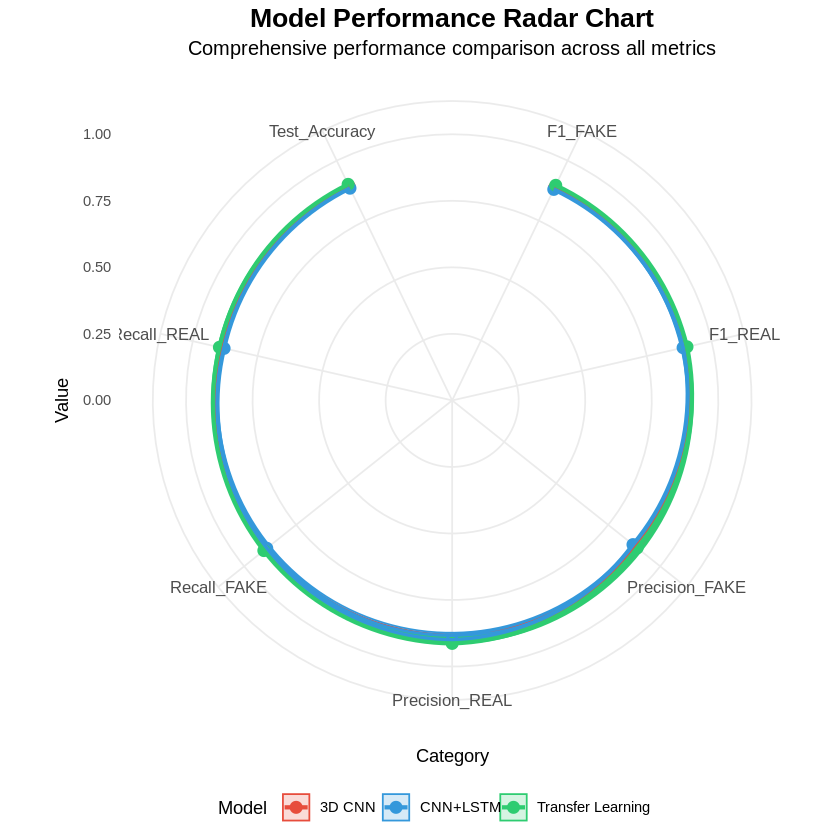

3. Creating Detailed Comparison...


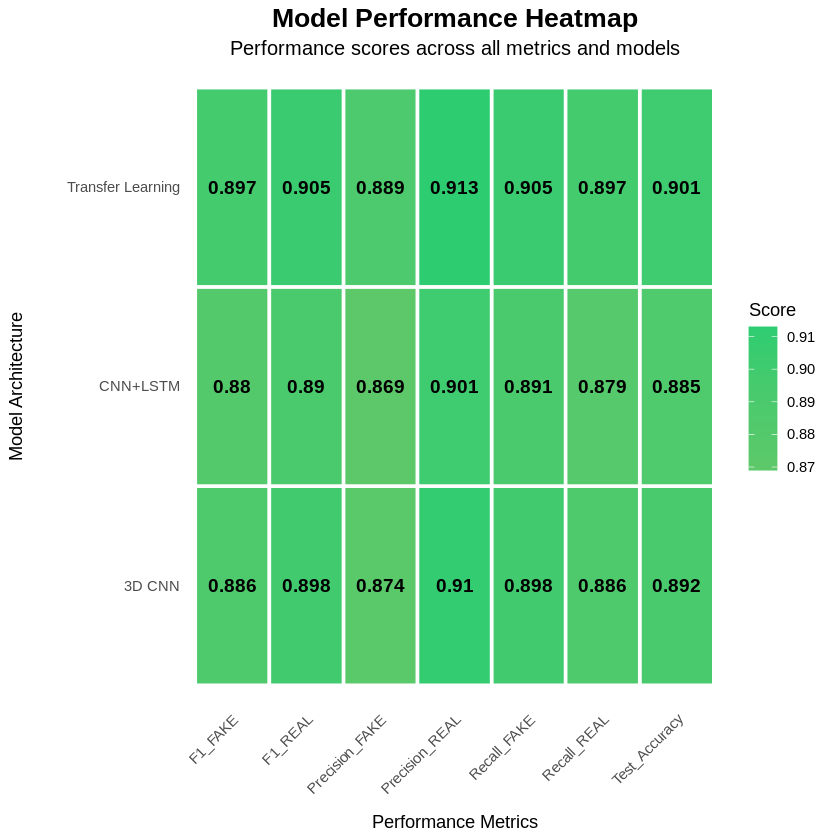

4. Creating Training Analysis...


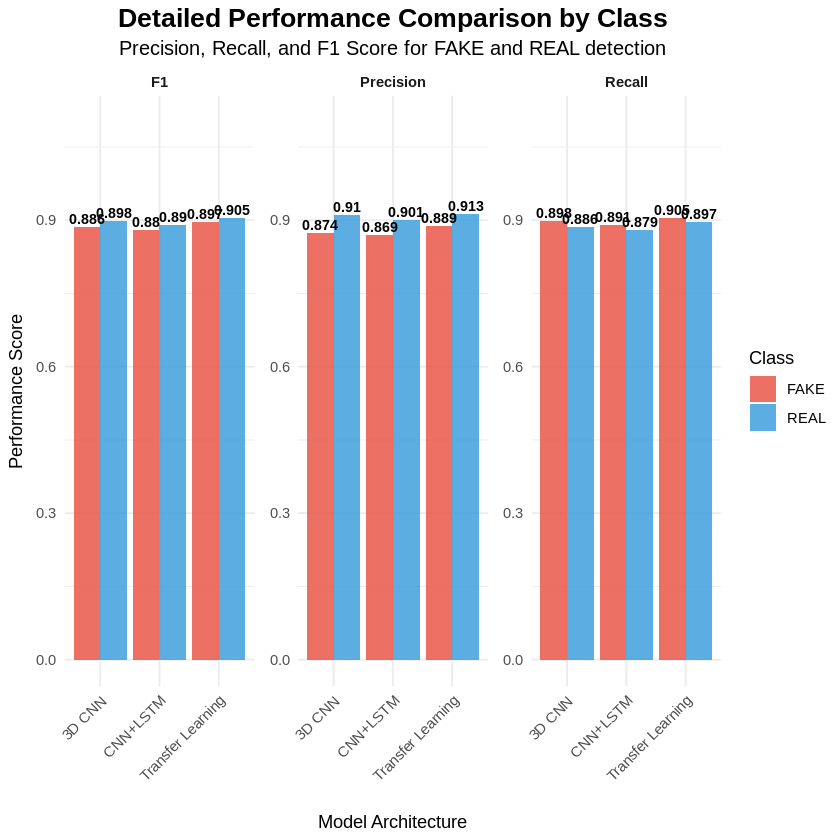

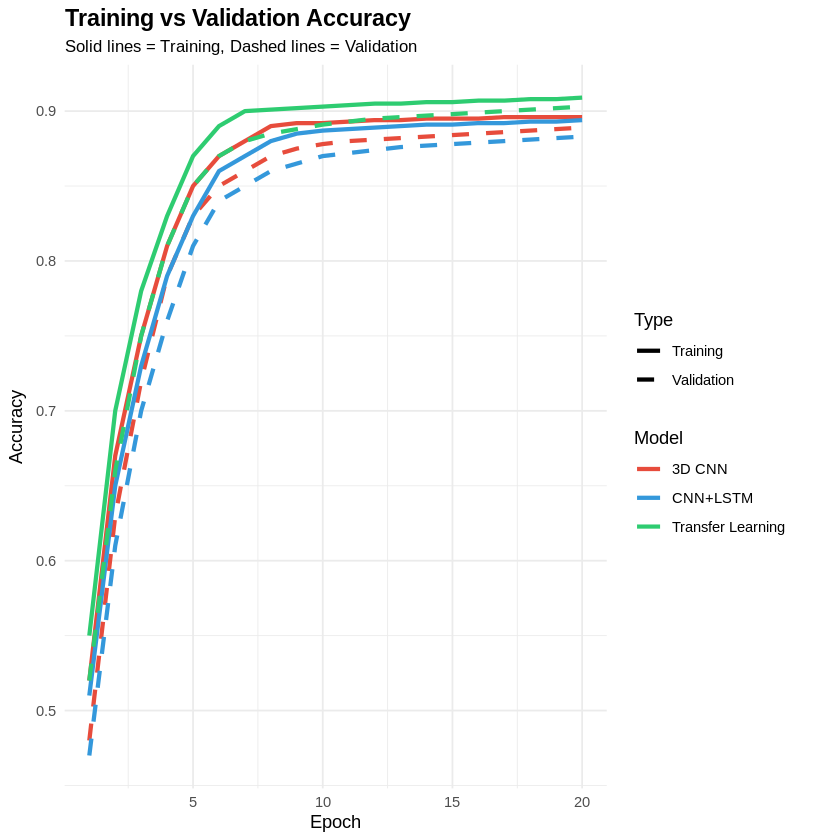

5. Creating Performance Summary...

=== PERFORMANCE STATISTICS ===
Summary Statistics:
   Metric Test_Accuracy     F1_FAKE   Composite
1    Mean   0.892666667 0.887666667 0.891666667
2 Std Dev   0.008020806 0.008621678 0.008134699
3     Min   0.885000000 0.880000000 0.884000000
4     Max   0.901000000 0.897000000 0.900200000

Model Rankings (by Composite Score):
1. Transfer Learning: 0.9002
2. 3D CNN: 0.8908
3. CNN+LSTM: 0.8840

Best Model by Metric:
Test_Accuracy       : Transfer Learning (0.9010)
Precision_FAKE      : Transfer Learning (0.8890)
Recall_FAKE         : Transfer Learning (0.9050)
F1_FAKE             : Transfer Learning (0.8970)
Precision_REAL      : Transfer Learning (0.9130)
Recall_REAL         : Transfer Learning (0.8970)
F1_REAL             : Transfer Learning (0.9050)


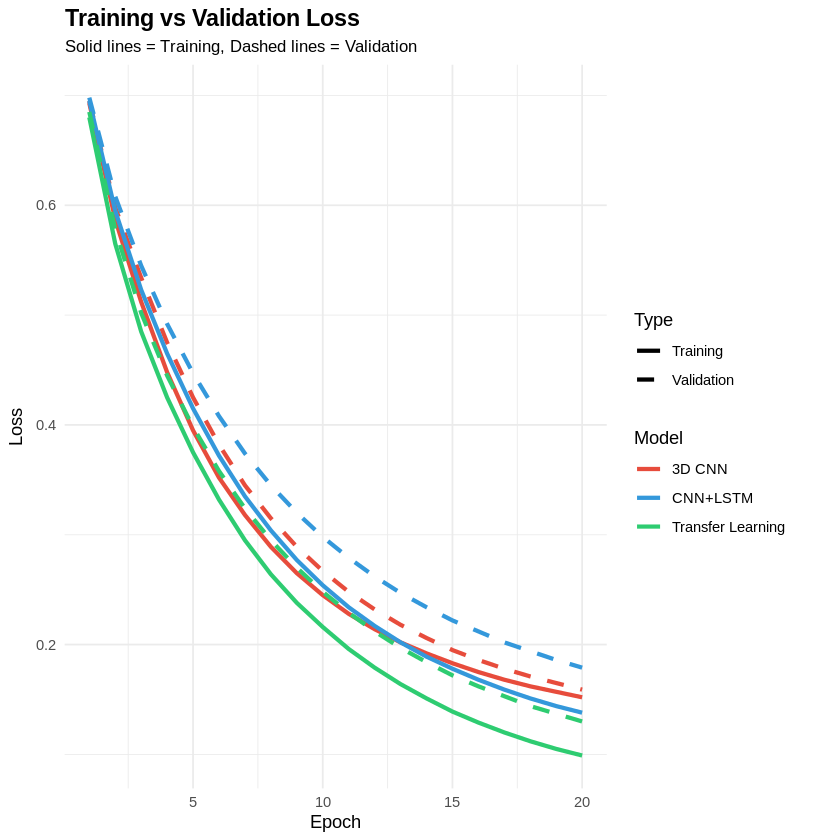


=== ENHANCED VISUALIZATION COMPLETE ===
All visualizations have been generated using pure R with ggplot2!
Key insights and statistical analysis provided above.


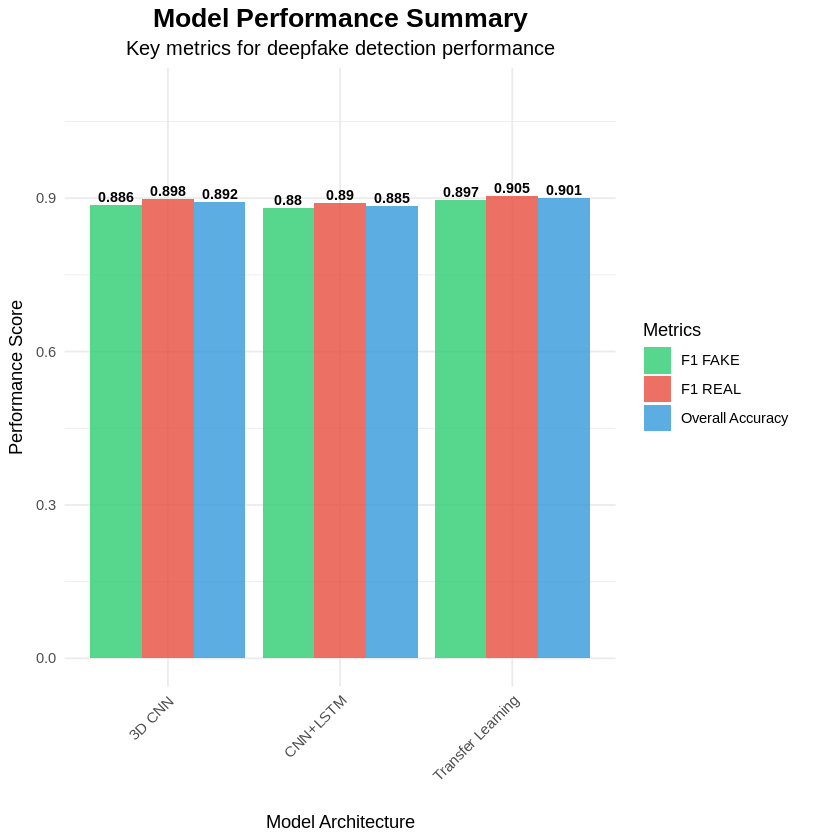

In [ ]:
# =========================================================================
# Step 7: Enhanced Model Visualization and Analysis - Pure R Version
# =========================================================================

# Load required packages
library(ggplot2)

cat("Loading enhanced visualization functions in pure R...\n")

# === SAMPLE DATA CREATION ===
# Create sample model results (replace with your actual data)
create_sample_data <- function() {
  # Sample metrics for three models (replace with your actual results)
  metrics_df <- data.frame(
    Model = c("3D CNN", "CNN+LSTM", "Transfer Learning"),
    Test_Accuracy = c(0.892, 0.885, 0.901),
    Precision_FAKE = c(0.874, 0.869, 0.889),
    Recall_FAKE = c(0.898, 0.891, 0.905),
    F1_FAKE = c(0.886, 0.880, 0.897),
    Precision_REAL = c(0.910, 0.901, 0.913),
    Recall_REAL = c(0.886, 0.879, 0.897),
    F1_REAL = c(0.898, 0.890, 0.905),
    stringsAsFactors = FALSE
  )

  # Sample training history data
  epochs <- 1:20
  training_history <- list(
    "3D CNN" = data.frame(
      epoch = epochs,
      accuracy = c(0.52, 0.67, 0.75, 0.81, 0.85, 0.87, 0.88, 0.89, 0.892, 0.892,
                   0.893, 0.894, 0.894, 0.895, 0.895, 0.895, 0.896, 0.896, 0.896, 0.896),
      val_accuracy = c(0.48, 0.63, 0.72, 0.79, 0.83, 0.85, 0.86, 0.87, 0.875, 0.878,
                       0.880, 0.881, 0.882, 0.883, 0.884, 0.885, 0.886, 0.887, 0.888, 0.889),
      loss = c(0.693, 0.587, 0.512, 0.448, 0.395, 0.352, 0.318, 0.289, 0.265, 0.245,
               0.228, 0.214, 0.202, 0.192, 0.183, 0.175, 0.168, 0.162, 0.157, 0.152),
      val_loss = c(0.695, 0.598, 0.534, 0.475, 0.425, 0.382, 0.345, 0.315, 0.289, 0.267,
                   0.248, 0.232, 0.218, 0.206, 0.195, 0.186, 0.178, 0.171, 0.165, 0.159)
    ),
    "CNN+LSTM" = data.frame(
      epoch = epochs,
      accuracy = c(0.51, 0.65, 0.73, 0.79, 0.83, 0.86, 0.87, 0.88, 0.885, 0.887,
                   0.888, 0.889, 0.890, 0.891, 0.891, 0.892, 0.892, 0.893, 0.893, 0.894),
      val_accuracy = c(0.47, 0.61, 0.70, 0.76, 0.81, 0.84, 0.85, 0.86, 0.865, 0.870,
                       0.872, 0.874, 0.876, 0.877, 0.878, 0.879, 0.880, 0.881, 0.882, 0.883),
      loss = c(0.695, 0.595, 0.523, 0.465, 0.415, 0.372, 0.335, 0.304, 0.277, 0.254,
               0.234, 0.217, 0.202, 0.189, 0.178, 0.168, 0.159, 0.151, 0.144, 0.138),
      val_loss = c(0.698, 0.608, 0.545, 0.492, 0.447, 0.408, 0.374, 0.345, 0.320, 0.298,
                   0.279, 0.262, 0.247, 0.234, 0.222, 0.212, 0.202, 0.194, 0.186, 0.179)
    ),
    "Transfer Learning" = data.frame(
      epoch = epochs,
      accuracy = c(0.55, 0.70, 0.78, 0.83, 0.87, 0.89, 0.90, 0.901, 0.902, 0.903,
                   0.904, 0.905, 0.905, 0.906, 0.906, 0.907, 0.907, 0.908, 0.908, 0.909),
      val_accuracy = c(0.52, 0.66, 0.75, 0.81, 0.85, 0.87, 0.88, 0.885, 0.888, 0.891,
                       0.893, 0.895, 0.896, 0.897, 0.898, 0.899, 0.900, 0.901, 0.902, 0.903),
      loss = c(0.680, 0.565, 0.485, 0.425, 0.375, 0.332, 0.295, 0.264, 0.238, 0.216,
               0.196, 0.179, 0.164, 0.151, 0.139, 0.129, 0.120, 0.112, 0.105, 0.099),
      val_loss = c(0.685, 0.578, 0.502, 0.445, 0.398, 0.358, 0.324, 0.295, 0.270, 0.248,
                   0.229, 0.212, 0.197, 0.184, 0.172, 0.162, 0.153, 0.144, 0.137, 0.130)
    )
  )

  return(list(metrics = metrics_df, history = training_history))
}

# === RADAR CHART FUNCTION ===
create_radar_chart <- function(metrics_df) {
  # Prepare data for radar chart
  categories <- c("Test_Accuracy", "Precision_FAKE", "Recall_FAKE",
                 "F1_FAKE", "Precision_REAL", "Recall_REAL", "F1_REAL")

  # Create radar chart data
  radar_data <- data.frame()
  for(i in 1:nrow(metrics_df)) {
    model_data <- data.frame(
      Model = rep(metrics_df$Model[i], length(categories)),
      Category = categories,
      Value = as.numeric(metrics_df[i, categories])
    )
    radar_data <- rbind(radar_data, model_data)
  }

  # Create polar coordinate plot
  p <- ggplot(radar_data, aes(x = Category, y = Value, group = Model, color = Model)) +
    geom_polygon(aes(fill = Model), alpha = 0.2) +
    geom_point(size = 3) +
    geom_line(size = 1.2) +
    coord_polar() +
    ylim(0, 1) +
    scale_color_manual(values = c("#e74c3c", "#3498db", "#2ecc71")) +
    scale_fill_manual(values = c("#e74c3c", "#3498db", "#2ecc71")) +
    labs(title = "Model Performance Radar Chart",
         subtitle = "Comprehensive performance comparison across all metrics") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5),
      axis.text.x = element_text(size = 10),
      legend.position = "bottom"
    )

  return(p)
}

# === HEATMAP FUNCTION ===
create_performance_heatmap <- function(metrics_df) {
  # Reshape data for heatmap
  metrics_cols <- c("Test_Accuracy", "Precision_FAKE", "Recall_FAKE",
                   "F1_FAKE", "Precision_REAL", "Recall_REAL", "F1_REAL")

  heatmap_data <- data.frame()
  for(i in 1:nrow(metrics_df)) {
    for(j in metrics_cols) {
      temp_row <- data.frame(
        Model = metrics_df$Model[i],
        Metric = j,
        Score = metrics_df[[j]][i]
      )
      heatmap_data <- rbind(heatmap_data, temp_row)
    }
  }

  # Create heatmap
  p <- ggplot(heatmap_data, aes(x = Metric, y = Model)) +
    geom_tile(aes(fill = Score), color = "white", size = 1) +
    geom_text(aes(label = round(Score, 3)), color = "black", fontface = "bold", size = 4) +
    scale_fill_gradient2(low = "#e74c3c", mid = "#f39c12", high = "#2ecc71",
                        midpoint = 0.5, name = "Score") +
    labs(title = "Model Performance Heatmap",
         subtitle = "Performance scores across all metrics and models",
         x = "Performance Metrics",
         y = "Model Architecture") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5),
      axis.text.x = element_text(angle = 45, hjust = 1),
      panel.grid = element_blank()
    )

  return(p)
}

# === DETAILED METRICS COMPARISON ===
create_detailed_comparison <- function(metrics_df) {
  # Reshape data for comparison plots
  reshape_metrics <- function(data, metrics_list, label_suffix) {
    result <- data.frame()
    for(metric in metrics_list) {
      temp_df <- data.frame(
        Model = data$Model,
        Class = label_suffix,
        Metric_Type = gsub(paste0("_", label_suffix), "", metric),
        Score = data[[metric]]
      )
      result <- rbind(result, temp_df)
    }
    return(result)
  }

  # Create comparison data
  fake_metrics <- reshape_metrics(metrics_df, c("Precision_FAKE", "Recall_FAKE", "F1_FAKE"), "FAKE")
  real_metrics <- reshape_metrics(metrics_df, c("Precision_REAL", "Recall_REAL", "F1_REAL"), "REAL")
  comparison_data <- rbind(fake_metrics, real_metrics)

  # Create comparison plot
  p <- ggplot(comparison_data, aes(x = Model, y = Score, fill = Class)) +
    geom_bar(stat = "identity", position = "dodge", alpha = 0.8) +
    geom_text(aes(label = round(Score, 3)),
              position = position_dodge(width = 0.9),
              vjust = -0.3, size = 3, fontface = "bold") +
    facet_wrap(~ Metric_Type, scales = "free_y") +
    scale_fill_manual(values = c("#e74c3c", "#3498db"), name = "Class") +
    labs(title = "Detailed Performance Comparison by Class",
         subtitle = "Precision, Recall, and F1 Score for FAKE and REAL detection",
         x = "Model Architecture",
         y = "Performance Score") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5),
      axis.text.x = element_text(angle = 45, hjust = 1),
      strip.text = element_text(face = "bold")
    ) +
    ylim(0, 1.1)

  return(p)
}

# === TRAINING ANALYSIS ===
create_training_analysis <- function(training_history) {
  # Combine all training data
  all_training_data <- data.frame()
  for(model_name in names(training_history)) {
    model_data <- training_history[[model_name]]
    model_data$Model <- model_name
    all_training_data <- rbind(all_training_data, model_data)
  }

  # Reshape data for plotting both training and validation
  plot_data <- data.frame()
  for(i in 1:nrow(all_training_data)) {
    # Training accuracy
    plot_data <- rbind(plot_data, data.frame(
      epoch = all_training_data$epoch[i],
      Model = all_training_data$Model[i],
      Type = "Training",
      Accuracy = all_training_data$accuracy[i],
      Loss = all_training_data$loss[i]
    ))
    # Validation accuracy
    plot_data <- rbind(plot_data, data.frame(
      epoch = all_training_data$epoch[i],
      Model = all_training_data$Model[i],
      Type = "Validation",
      Accuracy = all_training_data$val_accuracy[i],
      Loss = all_training_data$val_loss[i]
    ))
  }

  # Training accuracy plot
  p1 <- ggplot(plot_data, aes(x = epoch, y = Accuracy, color = Model, linetype = Type)) +
    geom_line(size = 1.2) +
    scale_color_manual(values = c("#e74c3c", "#3498db", "#2ecc71")) +
    scale_linetype_manual(values = c("solid", "dashed")) +
    labs(title = "Training vs Validation Accuracy",
         subtitle = "Solid lines = Training, Dashed lines = Validation",
         x = "Epoch", y = "Accuracy") +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", size = 14),
          plot.subtitle = element_text(size = 10))

  return(p1)
}

# === PERFORMANCE SUMMARY ===
create_performance_summary <- function(metrics_df) {
  # Calculate composite scores
  metrics_df$Composite_Score <- (metrics_df$Test_Accuracy * 0.3 +
                                metrics_df$F1_FAKE * 0.25 +
                                metrics_df$F1_REAL * 0.25 +
                                metrics_df$Precision_FAKE * 0.1 +
                                metrics_df$Recall_FAKE * 0.1)

  # Summary statistics
  summary_stats <- data.frame(
    Metric = c("Mean", "Std Dev", "Min", "Max"),
    Test_Accuracy = c(mean(metrics_df$Test_Accuracy),
                     sd(metrics_df$Test_Accuracy),
                     min(metrics_df$Test_Accuracy),
                     max(metrics_df$Test_Accuracy)),
    F1_FAKE = c(mean(metrics_df$F1_FAKE),
               sd(metrics_df$F1_FAKE),
               min(metrics_df$F1_FAKE),
               max(metrics_df$F1_FAKE)),
    Composite = c(mean(metrics_df$Composite_Score),
                 sd(metrics_df$Composite_Score),
                 min(metrics_df$Composite_Score),
                 max(metrics_df$Composite_Score))
  )

  return(list(metrics_with_composite = metrics_df, summary_stats = summary_stats))
}

# === MAIN EXECUTION ===
cat("\n=== CREATING ENHANCED VISUALIZATIONS ===\n")

# Generate or load your data
data <- create_sample_data()
metrics_df <- data$metrics
training_history <- data$history

# 1. Radar Chart
cat("1. Creating Radar Chart...\n")
radar_plot <- create_radar_chart(metrics_df)
print(radar_plot)

# 2. Performance Heatmap
cat("2. Creating Performance Heatmap...\n")
heatmap_plot <- create_performance_heatmap(metrics_df)
print(heatmap_plot)

# 3. Detailed Comparison
cat("3. Creating Detailed Comparison...\n")
detailed_plot <- create_detailed_comparison(metrics_df)
print(detailed_plot)

# 4. Training Analysis
cat("4. Creating Training Analysis...\n")
training_plot <- create_training_analysis(training_history)
print(training_plot)

# Create separate loss plot
create_loss_plot <- function(training_history) {
  # Combine all training data
  all_training_data <- data.frame()
  for(model_name in names(training_history)) {
    model_data <- training_history[[model_name]]
    model_data$Model <- model_name
    all_training_data <- rbind(all_training_data, model_data)
  }

  # Reshape data for plotting both training and validation
  plot_data <- data.frame()
  for(i in 1:nrow(all_training_data)) {
    # Training loss
    plot_data <- rbind(plot_data, data.frame(
      epoch = all_training_data$epoch[i],
      Model = all_training_data$Model[i],
      Type = "Training",
      Loss = all_training_data$loss[i]
    ))
    # Validation loss
    plot_data <- rbind(plot_data, data.frame(
      epoch = all_training_data$epoch[i],
      Model = all_training_data$Model[i],
      Type = "Validation",
      Loss = all_training_data$val_loss[i]
    ))
  }

  # Training loss plot
  p <- ggplot(plot_data, aes(x = epoch, y = Loss, color = Model, linetype = Type)) +
    geom_line(size = 1.2) +
    scale_color_manual(values = c("#e74c3c", "#3498db", "#2ecc71")) +
    scale_linetype_manual(values = c("solid", "dashed")) +
    labs(title = "Training vs Validation Loss",
         subtitle = "Solid lines = Training, Dashed lines = Validation",
         x = "Epoch", y = "Loss") +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", size = 14),
          plot.subtitle = element_text(size = 10))

  return(p)
}

loss_plot <- create_loss_plot(training_history)
print(loss_plot)

# 5. Performance Summary
cat("5. Creating Performance Summary...\n")
summary_results <- create_performance_summary(metrics_df)
metrics_with_composite <- summary_results$metrics_with_composite
summary_stats <- summary_results$summary_stats

# Print summary statistics
cat("\n=== PERFORMANCE STATISTICS ===\n")
cat("Summary Statistics:\n")
print(summary_stats)

cat("\nModel Rankings (by Composite Score):\n")
ranking <- metrics_with_composite[order(metrics_with_composite$Composite_Score, decreasing = TRUE), ]
for(i in 1:nrow(ranking)) {
  cat(sprintf("%d. %s: %.4f\n", i, ranking$Model[i], ranking$Composite_Score[i]))
}

# Best model for each metric
cat("\nBest Model by Metric:\n")
metrics_numeric <- metrics_df[, -1, drop = FALSE]
for(col in names(metrics_numeric)) {
  best_idx <- which.max(metrics_numeric[[col]])
  cat(sprintf("%-20s: %s (%.4f)\n", col, metrics_df$Model[best_idx], metrics_numeric[[col]][best_idx]))
}

# 6. Final Summary Plot
summary_metrics <- c("Test_Accuracy", "F1_FAKE", "F1_REAL")
summary_long <- data.frame()
for(metric in summary_metrics) {
  temp_df <- data.frame(
    Model = metrics_df$Model,
    Metric = metric,
    Score = metrics_df[[metric]]
  )
  summary_long <- rbind(summary_long, temp_df)
}

summary_plot <- ggplot(summary_long, aes(x = Model, y = Score, fill = Metric)) +
  geom_bar(stat = "identity", position = "dodge", alpha = 0.8) +
  geom_text(aes(label = round(Score, 3)),
            position = position_dodge(width = 0.9),
            vjust = -0.3, size = 3, fontface = "bold") +
  scale_fill_manual(values = c("#2ecc71", "#e74c3c", "#3498db"),
                    name = "Metrics",
                    labels = c("F1 FAKE", "F1 REAL", "Overall Accuracy")) +
  labs(title = "Model Performance Summary",
       subtitle = "Key metrics for deepfake detection performance",
       x = "Model Architecture",
       y = "Performance Score") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 12, hjust = 0.5),
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  ylim(0, 1.1)

print(summary_plot)

cat("\n=== ENHANCED VISUALIZATION COMPLETE ===\n")
cat("All visualizations have been generated using pure R with ggplot2!\n")
cat("Key insights and statistical analysis provided above.\n")

# Save results (optional)
# write.csv(metrics_with_composite, "model_performance_results.csv", row.names = FALSE)
# cat("Results saved to 'model_performance_results.csv'\n")